In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec

In [3]:
#모멘텀 전략 portfolio

#Data Call
Data_P = pd.ExcelFile('Data_MSCI_m.xlsx').parse('Price').set_index('Date')
Data_TR = pd.ExcelFile('Data_MSCI_m.xlsx').parse('TR').set_index('Date')

In [6]:
#HPR(Except RF)
HPR = Data_TR.pct_change()*100 #pct_change .shift(1)안해도 전기간대비 수익률 퍼센트로 보여줌
HPR['CD1m']=Data_TR['CD1m'].shift(1)/12

In [7]:
#Sector Price / KOR 값 Drop
sector_P = Data_P.drop(Data_P.columns[[0]], axis = 1) #첫번째 column인 KOR 제거

In [8]:
#Sector Momentum
sector_m = (sector_P / sector_P.shift(12)-1)*100

In [9]:
#Sector Ranking
sector_m[sector_m<0]=0 #(-)수익률이면 투자안한다.
sector_r = sector_m[sector_m>0].rank(axis=1,ascending=False) 
sector_r.iloc[12:,:] = sector_r.iloc[12:,:].fillna(value=0) #결측치를 0으로

In [10]:
for i in range (0,len(sector_r.index)): # (+)모멘텀섹터 갯수가 3개이하면 투자안함
    if sum(sector_r.iloc[i,:])<10:
        sector_r.iloc[i,:]=0    
        
for i in range (0,len(sector_r.index)): #rank가 1~4인 값들에 대해서만 weight배분
    if sum(sector_r.iloc[i,:])>=10:         
        sector_r.iloc[i,:][(sector_r.iloc[i,:]>4)]=0
        sector_r.iloc[i,:][(sector_r.iloc[i,:]!=0)]=0.25
        
sector_r['CD1m']=0.0  

for i in range (0,len(sector_r.index)):  #섹터투자대신 현금성자산(CD1m)에 투자
    if sum(sector_r.iloc[i,:])== 0 :
        sector_r.iloc[i,10] = 1.0

In [11]:
#Rp 
Rp = pd.DataFrame(((HPR.loc[:,'ENE':'CD1m'])*sector_r.shift()).sum(axis=1),columns=['Rp'])

In [12]:
Stdate = '2002-12-31'

Vp = Rp.loc[Stdate:,:]
Vp.iloc[0,0] = 0
Vp = (Vp/100 + 1).cumprod()*100
Vp.columns = ['Vp']

/usr/local/lib/python3.5/dist-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [13]:
#Rm (series 형태)
Rm = HPR.iloc[:,0].copy()

Date = Data_P.index
stDateNum = 20021231
stDate = pd.to_datetime(str(stDateNum),format = '%Y%m%d')
idx = np.argmin(np.abs(Date - stDate))

Time = Date[idx:].copy()
numData = Time.shape[0]

In [14]:
#변수 날짜 설정(Stdate 시점으로 고정)
Rm_= Rm[idx:]

#K200 Portfolio

K200 = pd.Series(np.zeros(numData))
K200[0] = 100
for t in range (1,numData):
    K200[t] = K200[t-1]*(1+Rm_[t]/100)


In [15]:
#MDD 도출

#모멘텀 MDD
Vmax = Vp.cummax()
MDD_V = (Vp/Vmax-1)*100

#K200 MDD
Kmax = K200.cummax()
MDD_K200 = (K200/Kmax-1)*100

/usr/local/lib/python3.5/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


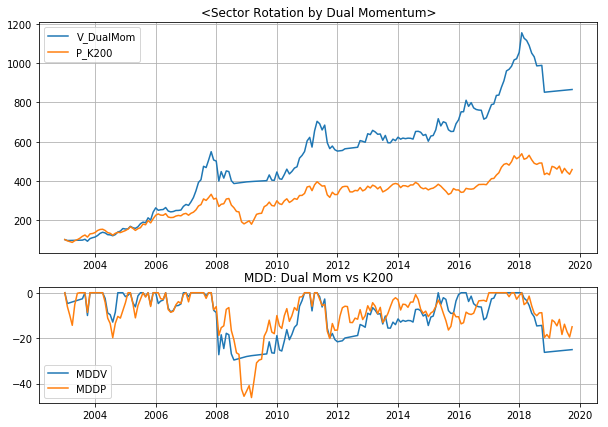

In [16]:
## 그래프 그리기
fig = plt.figure(figsize = (10,7))
gs = gridspec.GridSpec(nrows=2,
                       ncols =1,
                       height_ratios= [8,4],
                       width_ratios= [5]) #subplot의 크기를 서로 다르게 설정

#Value
ax0 = plt.subplot(gs[0])
ax0.plot(Time,Vp, label = 'V_DualMom');
ax0.plot(Time,K200, label = 'P_K200');
plt.title('<Sector Rotation by Dual Momentum>')
ax0.grid(True)
ax0.legend()

#MDD
ax1 = plt.subplot(gs[1])
ax1.plot(Time, MDD_V, label = 'MDDV');
ax1.plot(Time,MDD_K200, label = 'MDDP');
plt.title('MDD: Dual Mom vs K200')
ax1.grid(True)
ax1.legend()